# Report It! Newport Data Analysis
This notebook runs through some basic analysis of [Report It! Newport](https://engagenewport.com/report-a-problem) data, which uses the  [SeeClickFix](http://www.seeclickfix.com) app.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Clone the seeclickfix archive from [here](https://github.com/NewportDataPortal/seeclickfix-archive)

In [2]:
datafile = '../../Datasets/seeclickfix-archive/newport_2_issues_archive.json'
issues = pd.read_json(datafile, orient="records")
issues['request_type'] = issues['request_type.title'].astype('category')
# drop uncategorized issues
issues = issues.dropna(axis=0, subset=['request_type'])

In [3]:
issues.request_type.describe()

count                          1043
unique                           16
top       Roadway or Sidewalk Issue
freq                            216
Name: request_type, dtype: object

In [4]:
type_colors={}
for i in range(0,len(issues.request_type.cat.categories)):
    type_colors[issues.request_type.cat.categories[i]] = i
type_colors

{'Beach Issue': 0,
 'Cliff Walk Issue': 1,
 'Graffiti Issue': 2,
 'Missed Trash or Bulky Waste Collection': 3,
 'Other': 4,
 'Playground Issue': 5,
 'Pothole Issue': 6,
 'Public Restroom Issue': 7,
 'Recreation Facility, Sports Field or Park Issue': 8,
 'Roadway or Sidewalk Issue': 9,
 'Snow Issue': 10,
 'Storm Drain': 11,
 'Street Light Issue': 12,
 'Thank a City Employee': 13,
 'Traffic Sign/Pavement Marking Issue': 14,
 'Tree or Vegetation Issue': 15}

In [5]:
# define a colormap for plotting the issues
from branca.colormap import linear
colormap = linear.Spectral.scale(0,15)

## Issue Locations
In the first map, all the issues are plotted, colored by category.

In [6]:
import folium
from folium import features
NEWPORT_LATLON = (41.4901, -71.3128)
map = folium.Map(location=NEWPORT_LATLON, zoom_start=13)

map.add_child(colormap)

for each in issues.iterrows():
    folium.Circle(
        radius = 20,
        location = [each[1]['lat'],each[1]['lng']],
        popup = each[1]['request_type.title'],
        color = colormap(type_colors[each[1]['request_type']]),
    ).add_to(map)

map

Here's a heatmap of the issues, highlighting the density of reporting.

In [7]:
from folium.plugins import HeatMap

pts = issues[['lat','lng']]

m = folium.Map(location=NEWPORT_LATLON,tiles='Stamen Toner', zoom_start=13)

h = HeatMap(list(zip(list(pts.lat),list(pts.lng)))).add_to(m)

m

## Who's reporting?
Here's how many unique reporting ids there are:

In [8]:
print(len(issues['reporter.id'].unique()))

204


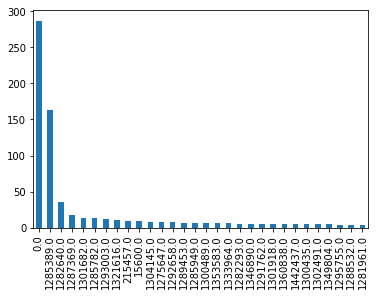

In [9]:
# plot the 30 most frequent reporters
issues['reporter.id'].value_counts().head(30).plot.bar()
plt.show()

It looks like the most frequent reporter is...

In [10]:
issues[issues['reporter.id']==0]['reporter.name'].iloc[0]

'An anonymous SeeClickFix user'

## Responses
What are the statisics for closing issues?

Longest open: 392 days 12:20:19
Mean time open: 35 days 01:45:45.050411
Median time open: 3 days 18:46:35.500000


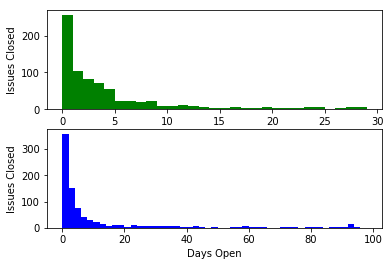

In [11]:
topen = issues.closed_at - issues.created_at
print('Longest open: ' + str(topen.max()))
print('Mean time open: ' + str(topen.mean()))
print('Median time open: ' + str(topen.median()))
fig, (ax1,ax2) = plt.subplots(2,1)
(topen/pd.Timedelta(days=1)).plot.hist(ax=ax1,bins=range(0,30,1),color="green")
ax1.set_xlabel("Days Open")
ax1.set_ylabel("Issues Closed")
(topen/pd.Timedelta(days=1)).plot.hist(ax=ax2,bins=range(0,100,2), color="blue")
ax2.set_xlabel("Days Open")
ax2.set_ylabel("Issues Closed")
plt.show()

In [12]:
now = pd.datetime.now()
still_open = issues[issues['closed_at'].isnull()]
hanging = now - still_open.created_at
print('Max age of currently open issues: ' + str(hanging.max()))
print('Mean age of currently open issues: ' + str(hanging.mean()))
print('Median age of currently open issues: ' + str(hanging.median()))

Max age of currently open issues: 577 days 12:37:12.954215
Mean age of currently open issues: 214 days 14:27:11.306327
Median age of currently open issues: 156 days 13:23:15.954215
